# Compare Puppi MET and Raw Puppi MET

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib
import vector
import math
import numpy as np
import matplotlib.gridspec as gridspec
vector.register_awkward()
from coffea.jetmet_tools import CorrectedJetsFactory, CorrectedMETFactory, JECStack
import coffea
import cachetools
coffea.__version__

'0.7.29'

In [2]:
def met_correction_after_jec(events, METcoll, jets_pre_jec, jets_post_jec):
    '''This function rescale the MET vector by minus delta of the jets after JEC correction
    and before the jEC correction.
    This can be used also to rescale the MET when updating on the fly the JEC calibration. '''
    orig_tot_px = ak.sum(jets_pre_jec.px, axis=1)
    orig_tot_py = ak.sum(jets_pre_jec.py, axis=1)
    new_tot_px = ak.sum(jets_post_jec.px, axis=1)
    new_tot_py = ak.sum(jets_post_jec.py, axis=1)
    newpx =  events[METcoll].px - (new_tot_px - orig_tot_px) 
    newpy =  events[METcoll].py - (new_tot_py - orig_tot_py) 
    
    newMetPhi = np.arctan2(newpy, newpx)
    newMetPt = (newpx**2 + newpy**2)**0.5
    return  {"pt": newMetPt, "phi": newMetPhi}



In [17]:
# filename="root://xrootd-cms.infn.it///store/mc/Run3Summer22NanoAODv12/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/forPOG_130X_mcRun3_2022_realistic_v5-v2/2540000/88d947b3-b5ca-452b-84c1-034b8d6eab66.root"
filename="/home/matteo-malucchi/software/DY.root"

events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=10000 ).events()

In [18]:
print(events.RawPuppiMET.pt)
print(events.PuppiMET.pt)

print(events.RawMET.pt)
print(events.MET.pt)

[7.47, 57.9, 25.2, 8.44, 13, 18.4, 30.7, ... 34.6, 33.5, 3.06, 44, 5.02, 16.7, 27.9]
[7.47, 76.5, 45.3, 10.9, 12, 17.7, 30.2, ... 45.4, 3.06, 49.1, 7.37, 22.7, 31.4]
[77.3, 52.8, 24, 10.7, 8.99, 26.5, 37.2, ... 66.4, 20.2, 14.4, 12.2, 19.7, 13.2]
[80.9, 72.1, 25.7, 13.3, 8.48, 26.9, 42.2, ... 77.7, 16.5, 23.3, 5.59, 24.1, 34.1]


In [19]:
jet_raw = ak.copy(events.Jet)
jet_raw_pt = jet_raw.pt * (
    1 - jet_raw.rawFactor
)  
jet_raw = ak.zip(
    {
        "pt": jet_raw_pt,
        "px": jet_raw_pt * np.cos(jet_raw.phi),
        "py": jet_raw_pt * np.sin(jet_raw.phi),
        "phi": jet_raw.phi,
        "eta": jet_raw.eta,
        "mass": jet_raw.mass
        * (
            1 - jet_raw.rawFactor
        ),  # Assuming rawFactor is the correct field for raw mass
        "pt_orig":jet_raw_pt,
        "pt_raw":jet_raw_pt,
    },
    with_name="Momentum4D",
)
jet = ak.zip(
    {
        "pt": events.Jet.pt,
        "px": events.Jet.pt * np.cos(events.Jet.phi),
        "py": events.Jet.pt * np.sin(events.Jet.phi),
        "phi": events.Jet.phi,
        "eta": events.Jet.eta,
        "mass": events.Jet.mass,
        "pt_orig":jet_raw_pt,
        "pt_raw":jet_raw_pt,
    },
    with_name="Momentum4D",
)

# mask_jet = jet.pt>=14.99
# print("efficiency of jets:", ak.sum(mask_jet) / ak.count(jet.pt))

# jet_not = jet[~mask_jet]
# print("jets not passing pt cut:", ak.to_numpy(jet_not.pt[ak.num(jet_not.pt) > 0]))

# jet = jet[mask_jet]
# jet_raw = jet_raw[mask_jet]

In [20]:
cal_met = met_correction_after_jec(events, "RawPuppiMET", jet_raw, jet)
cal_met = ak.zip(
    {
        "pt": cal_met["pt"],
        "phi": cal_met["phi"],
    },
    with_name="Momentum4D",
)

raw_met = met_correction_after_jec(events, "PuppiMET", jet, jet_raw)
raw_met = ak.zip(
    {
        "pt": raw_met["pt"],
        "phi": raw_met["phi"],
    },
    with_name="Momentum4D",
)


In [21]:
print("Raw Puppi MET pt:", events.RawPuppiMET.pt)
print("Raw recomputed Puppi MET pt:", raw_met.pt)
print(" Puppi MET pt:", events.PuppiMET.pt)
print("Corrected Puppi MET pt:", cal_met.pt)


Raw Puppi MET pt: [7.47, 57.9, 25.2, 8.44, 13, 18.4, 30.7, ... 34.6, 33.5, 3.06, 44, 5.02, 16.7, 27.9]
Raw recomputed Puppi MET pt: [7.47, 58, 25.2, 11.7, 13.1, 18.4, 30.7, ... 34.7, 33.6, 1.87, 44, 11.1, 15.9, 27.9]
 Puppi MET pt: [7.47, 76.5, 45.3, 10.9, 12, 17.7, 30.2, ... 45.4, 3.06, 49.1, 7.37, 22.7, 31.4]
Corrected Puppi MET pt: [7.47, 76.4, 45.3, 7.75, 12, 17.7, 30.2, ... 38, 45.3, 4.25, 49.1, 8.29, 23.9, 31.4]


In [22]:
event_num=-1




print(jet.pt[event_num])
print(jet_raw.pt[event_num])


print("Raw Puppi MET pt:", events.RawPuppiMET.pt[event_num])
print(" Puppi MET pt:", events.PuppiMET.pt[event_num])
print("Corrected Puppi MET pt:", cal_met.pt[event_num])

[70, 57.8, 20.5]
[61.7, 49.9, 18.1]
Raw Puppi MET pt: 27.890625
 Puppi MET pt: 31.401044845581055
Corrected Puppi MET pt: 31.396825790405273


In [23]:
ratio_met=events.PuppiMET.pt/cal_met.pt

[1, 1, 1, 1.4, 1.01, 1, 1, 1.01, 1, ... 0.915, 2.4, 1, 1, 0.721, 1, 0.889, 0.952, 1]
1.00079921875
0.9997804


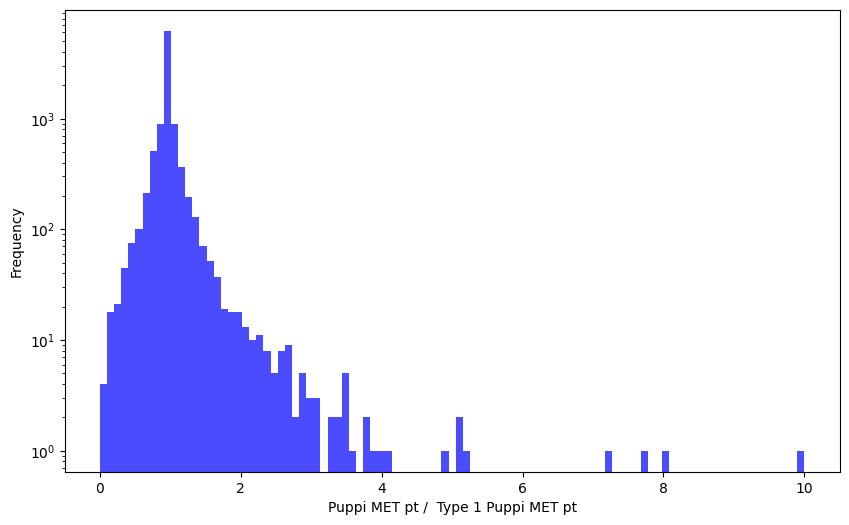

In [24]:
print(ratio_met)

print(np.mean(ratio_met))
print(np.median(ratio_met))

# plot histo of ratio_met
plt.figure(figsize=(10, 6))
plt.hist(ratio_met, bins=np.linspace(0., 10, 100), alpha=0.7, label='Ratio MET / Corrected MET', color='blue')
plt.yscale('log')
plt.xlabel('Puppi MET pt /  Type 1 Puppi MET pt')
plt.ylabel('Frequency')
plt.show()

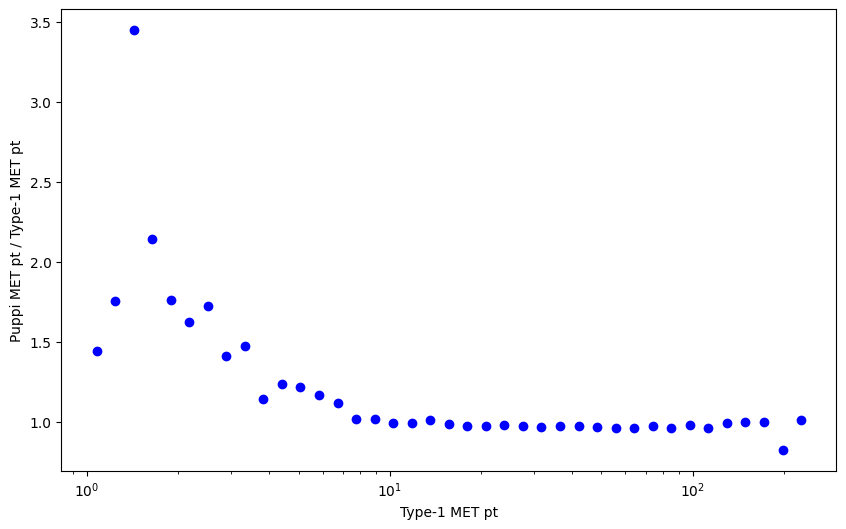

In [25]:
#plot the average of the ratio for different bins of cal_met
bins_met= np.logspace(0, 3, 50)  # Bins for MET pt from 1 to 1000
bin_means = []
bin_edges = []
for i in range(len(bins_met) - 1):
    mask = (cal_met.pt >= bins_met[i]) & (cal_met.pt < bins_met[i + 1])
    if ak.count(cal_met.pt[mask]) > 0:
        bin_mean = ak.mean(ratio_met[mask])
        bin_means.append(bin_mean)
        bin_edges.append((bins_met[i] + bins_met[i + 1]) / 2)
        
plt.figure(figsize=(10, 6))
plt.errorbar(bin_edges, bin_means, yerr=ak.std(ratio_met[mask]), fmt='o', label='Mean Ratio MET / Corrected MET', color='blue')
plt.xlabel('Type-1 MET pt')
plt.ylabel('Puppi MET pt / Type-1 MET pt')
plt.xscale('log')
plt.show()


In [26]:
low_pt_jet=events.CorrT1METJet.rawPt
print(low_pt_jet, ak.min(low_pt_jet))

# correct the met
# cal_met_low_pt = met_correction_after_jec(events, "RawPuppiMET", jet_raw, low_pt_jet)

[[8.48], [9.02], [10.5, 13.3, 8.55, 7.13, ... [10.9, 7.35, 6.98], [10.3, 11.5, 7.81]] 5.5039062


# Use the coffea MET factory

In [27]:
jec_inputs={}

jec_stack = JECStack(jec_inputs)

name_map = jec_stack.blank_name_map
name_map["JetPt"] = "pt"
name_map["JetMass"] = "mass"
name_map["JetEta"] = "eta"
name_map["JetA"] = "area"

jets = events.Jet

jets["pt_raw"] = (1 - jets["rawFactor"]) * jets.pt
jets["mass_raw"] = (1 - jets["rawFactor"]) * jets.mass
jets["pt_gen"] = ak.fill_none(jets.matched_gen.pt, 0)
# jets["rho"] = events.fixedGridRhoFastjetAll
name_map["ptGenJet"] = "pt_gen"
name_map["ptRaw"] = "pt_raw"
name_map["massRaw"] = "mass_raw"
# name_map["Rho"] = "rho"

name_map["METpt"] = "pt"
name_map["METphi"] = "phi"
name_map["JetPhi"] = "phi"
name_map["UnClusteredEnergyDeltaX"] = "MetUnclustEnUpDeltaX"
name_map["UnClusteredEnergyDeltaY"] = "MetUnclustEnUpDeltaY"

print(name_map)

puppi_met=ak.with_field(events.PuppiMET,
                        ak.zeros_like(events.PuppiMET.pt),
                        "MetUnclustEnUpDeltaX")
puppi_met=ak.with_field(puppi_met,
                        ak.zeros_like(events.PuppiMET.pt),
                        "MetUnclustEnUpDeltaY")

raw_puppi_met=ak.with_field(events.RawPuppiMET,
                        ak.zeros_like(events.RawPuppiMET.pt),
                        "MetUnclustEnUpDeltaX")
raw_puppi_met=ak.with_field(raw_puppi_met,
                        ak.zeros_like(events.RawPuppiMET.pt),
                        "MetUnclustEnUpDeltaY")

jet_factory = CorrectedJetsFactory(name_map, jec_stack)
met_factory = CorrectedMETFactory(name_map)
corrected_jets = jet

{'UnClusteredEnergyDeltaX': 'MetUnclustEnUpDeltaX', 'JetMass': 'mass', 'JetPt': 'pt', 'ptRaw': 'pt_raw', 'massRaw': 'mass_raw', 'METpt': 'pt', 'METphi': 'phi', 'JetPhi': 'phi', 'UnClusteredEnergyDeltaY': 'MetUnclustEnUpDeltaY', 'JetEta': 'eta', 'JetA': 'area', 'ptGenJet': 'pt_gen'}


In [28]:
corrected_met = met_factory.build(puppi_met, corrected_jets,cachetools.Cache(np.inf))
raw_corrected_met_with_raw = met_factory.build(raw_puppi_met, jet_raw,cachetools.Cache(np.inf))
raw_corrected_met = met_factory.build(raw_puppi_met, corrected_jets,cachetools.Cache(np.inf))

In [29]:
print(corrected_met.pt)
print(events.PuppiMET.pt)
print(events.RawPuppiMET.pt)
print(raw_corrected_met.pt)

[7.47, 95.3, 65.6, 10.1, 11, 17.1, 31, ... 41.5, 57.2, 4.25, 54.4, 5.03, 29.8, 34.9]
[7.47, 76.5, 45.3, 10.9, 12, 17.7, 30.2, ... 45.4, 3.06, 49.1, 7.37, 22.7, 31.4]
[7.47, 57.9, 25.2, 8.44, 13, 18.4, 30.7, ... 34.6, 33.5, 3.06, 44, 5.02, 16.7, 27.9]
[7.47, 76.4, 45.3, 7.75, 12, 17.7, 30.2, ... 38, 45.3, 4.25, 49.1, 8.29, 23.9, 31.4]


# MET comparisons       

In [30]:
print("Raw Puppi MET pt:", events.RawPuppiMET.pt)
print("Raw recomputed Puppi MET pt:", raw_met.pt)
print("met factory corrected_met", corrected_met.pt)

print("\n Puppi MET pt:", events.PuppiMET.pt)
print("Corrected Puppi MET pt:", cal_met.pt)
print("raw met factory corrected_met", raw_corrected_met.pt)
# print("raw met factory raw_corrected_met_with_raw", raw_corrected_met_with_raw.pt)


Raw Puppi MET pt: [7.47, 57.9, 25.2, 8.44, 13, 18.4, 30.7, ... 34.6, 33.5, 3.06, 44, 5.02, 16.7, 27.9]
Raw recomputed Puppi MET pt: [7.47, 58, 25.2, 11.7, 13.1, 18.4, 30.7, ... 34.7, 33.6, 1.87, 44, 11.1, 15.9, 27.9]
met factory corrected_met [7.47, 95.3, 65.6, 10.1, 11, 17.1, 31, ... 41.5, 57.2, 4.25, 54.4, 5.03, 29.8, 34.9]

 Puppi MET pt: [7.47, 76.5, 45.3, 10.9, 12, 17.7, 30.2, ... 45.4, 3.06, 49.1, 7.37, 22.7, 31.4]
Corrected Puppi MET pt: [7.47, 76.4, 45.3, 7.75, 12, 17.7, 30.2, ... 38, 45.3, 4.25, 49.1, 8.29, 23.9, 31.4]
raw met factory corrected_met [7.47, 76.4, 45.3, 7.75, 12, 17.7, 30.2, ... 38, 45.3, 4.25, 49.1, 8.29, 23.9, 31.4]
